In [1]:
#https://m-insideout.tistory.com/25

#how-to-cluster-images-based-on-visual-similarity-cd6e7209fe34

In [7]:
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
import random
from tqdm import tqdm

In [3]:
# load model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [4]:
def extract_features(path, model):
    # load the image as a 224x224 array
    img = load_img(path, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [5]:
train_dir = 'images'

# this list holds all the image filename
file_names = []

# creates a ScandirIterator aliased as files
with os.scandir(train_dir) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('g'):
          # adds only the image files
            file_names.append(train_dir + "/" +file.name)

In [8]:
file_names = random.sample(file_names, int(len(file_names) * 0.1))

In [9]:
data = {}

# lop through each image in the dataset
for i, file in tqdm(enumerate(file_names)):
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(file, model)
        data[file] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)

# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)

1088it [03:45,  4.82it/s]


In [32]:
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

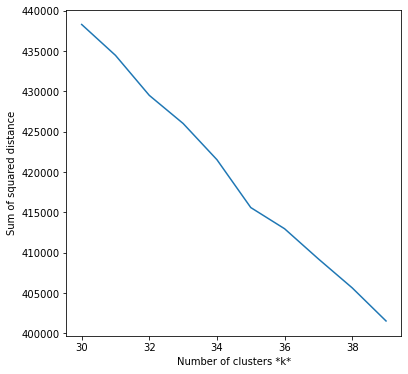

In [31]:
# this is just incase you want to see which value for k might be the best 
sse = []
list_k = list(range(30, 40))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22)
    km.fit(x)
    
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');
        

In [17]:
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

In [33]:
target_cluster = 16

kmeans = KMeans(n_clusters=target_cluster, random_state=22)
kmeans.fit(x)

# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [34]:
import os

result_path = 'result'

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

for i in range(target_cluster):
    createFolder(result_path + '/' + str(i))

In [35]:
import shutil


for i in range(target_cluster):
    for num, file in enumerate(groups[i]):
        shutil.copyfile(file, result_path + '/' + str(i) + '/' + str(num) + '.jpg')

Clipping cluster size from 65 to 30


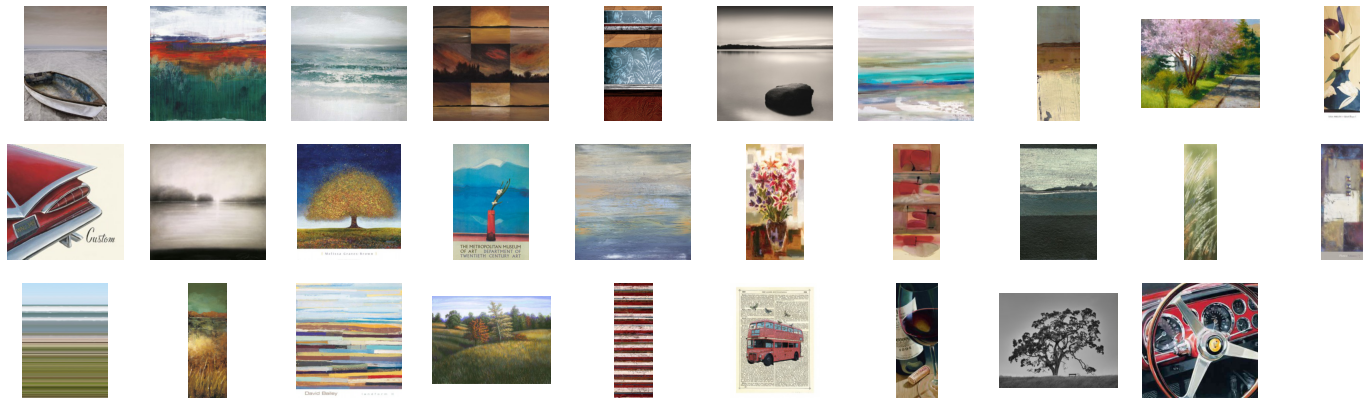

In [21]:
view_cluster(1)